# Import

In [1]:
# Import standard libraries
# Import third-party libraries
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.centrality import eigenvector_centrality
import pandas as pd
# Import local libraries

# Read  data

To identify and extract all patents from 2016 that have a patent classification (cpc) starting with G06Q30/06, we used the following query:

```sql
SELECT
  publications.publication_number as publication_number,
  publications.filing_date as filing_date,
  cpc.code as cpc_code
FROM
  `patents-public-data.patents.publications` as publications,
  UNNEST(cpc) AS cpc
WHERE
  cpc.code = 'G06Q30/06'
  AND publications.filing_date >= 20160101
  AND publications.filing_date <= 20161231
```

Then, to extract all the patents from 2016-2020 that cite these patents, we used the following query:

```sql
SELECT
  publications.publication_number as publication_number,
  publications.filing_date as filing_date,
  citation.publication_number as citation_publication_number
FROM
  `patents-public-data.patents.publications` as publications,
  UNNEST(citation) as citation
WHERE publications.filing_date >= 20160101 AND publications.filing_date <= 20201231 AND
citation.publication_number IN (
  SELECT
    publications.publication_number as publication_number
  FROM
    `patents-public-data.patents.publications` as publications,
    UNNEST(cpc) AS cpc
  WHERE
    cpc.code = 'G06Q30/06'
    AND publications.filing_date >= 20160101
    AND publications.filing_date <= 20161231 
  )
```

In [2]:
# read data that was saved from BigQuery
patents_cpc = pd.read_csv('bq_results_G06Q30.csv') # ending with cpc.code == G06Q30/06
patents_cite = pd.read_csv('bq_results_citations.csv') # all other patents citing the above

In [3]:
# check if we queried correctly, checking if all values in cited patents are among the G06Q30/06 patents
not_found = []
for i, row in patents_cite.iterrows():
    if row['citation_publication_number'] not in patents_cpc['publication_number'].values:
        not_found.append(row['citation_publication_number'])
print(len(not_found)) # if 0, good news

0


In [4]:
# clean after checking
patents_cpc = patents_cpc.drop(columns = ['filing_date', 'cpc_code'])
patents_cite = patents_cite.drop(columns = ['filing_date'])
patents_cite = patents_cite.rename(columns = {'citation_publication_number': 'citation'})

In [5]:
patents_cpc.head()

,publication_number
0,KR-20160124733-A
1,US-10268985-B1
2,KR-101860364-B1
3,KR-101860364-B1
4,JP-WO2017203630-A1


In [6]:
patents_cite.head()

,publication_number,citation
0,US-2017013294-A1,US-9609037-B2
1,US-2017300898-A1,US-2017213210-A1
2,US-2017263101-A1,US-2016210602-A1
3,US-2018005185-A1,US-2017200218-A1
4,US-2018144216-A1,US-2018033066-A1


In [7]:
patents_cite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849 entries, 0 to 1848
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   publication_number  1849 non-null   object
 1   citation            1849 non-null   object
dtypes: object(2)
memory usage: 29.0+ KB


In [8]:
# get unique elements in each column
print('Number of different patents citing: {}'.format(patents_cite['publication_number'].nunique()))
print('Number of different cited patents: {}'.format(patents_cite['citation'].nunique()))

Number of different patents citing: 1644
Number of different cited patents: 511


In [9]:
# we actually only need the dataframe with citations, drop duplicates to avoid double edges
patents_cite = patents_cite.drop_duplicates()

# Create graph

In [10]:
# for this we use the library networkx
G = nx.from_pandas_edgelist(df = patents_cite, source = 'publication_number',
                           target = 'citation', edge_attr = None, 
                           create_using = nx.DiGraph())

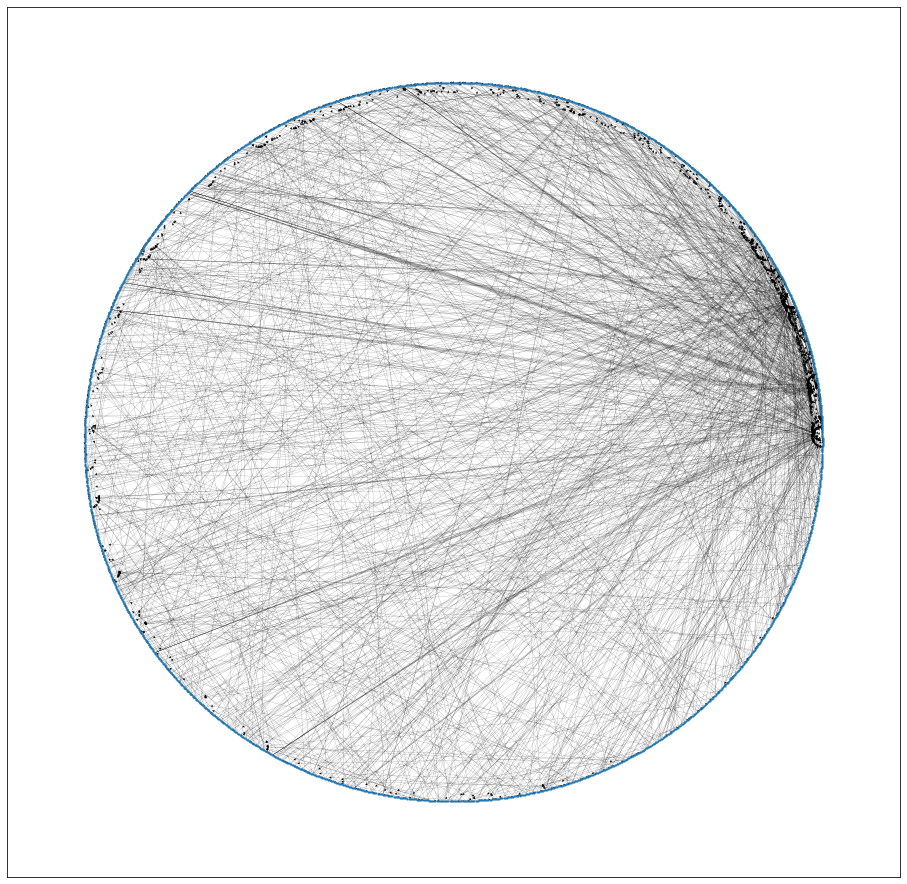

In [11]:
#draw network
fig, ax = plt.subplots(figsize = (16, 16))

pos = nx.circular_layout(G) # circular_layout, shell_layout, spring_layout, spiral_layout
nx.draw_networkx_nodes(G, pos, node_size = 1, ax = ax)
#nx.draw_networkx_labels(G, pos, ax = ax)
nx.draw_networkx_edges(G, pos, arrows = True, width = 0.1, arrowsize = 5, ax = ax)
plt.show()
# there seems to be a group of highly cited patents between 2 and 3 o'clock

# Analysis of relevant actors

In [12]:
# keep count of incoming edges for each node in citation column
num_in_edges = {}
for node in G.nodes:
    if node in patents_cite['citation'].values:
        num_in_edges[node] = len(G.in_edges(node))
# transform to pd.series
num_in_edges = pd.DataFrame(num_in_edges.items())
# sort descending
num_in_edges = num_in_edges.rename(columns = {0: 'application_number', 1: 'in_edges'})
num_in_edges = num_in_edges.sort_values(by = 'in_edges', ascending = False)
num_in_edges

,application_number,in_edges
2,US-2016210602-A1,96
67,CN-105976231-A,69
5,US-2017103468-A1,47
30,US-9530137-B2,43
89,US-2016284033-A1,32
...,...,...
337,KR-101734915-B1,1
338,KR-20170106684-A,1
339,US-2016275576-A1,1
340,KR-101689637-B1,1


A small search on Espacenet.com tells us that the most cited application number US-2016210602-A1 refers to a patent from DRESSBOT INC (CA) entitled "SYSTEM AND METHOD FOR COLLABORATIVE SHOPPING, BUSINESS AND ENTERTAINMENT"

The second most cited application number CN-105976231-A refers to a patent from SHENZHEN QIANHAI WEBANK CO LTD (CN) entitled "Asset management method based on intelligent block chain contracts and nodes"

In [13]:
num_cited = 10
print('There are {} patents that have been cited at least {} times'.\
      format(len(num_in_edges[num_in_edges['in_edges'] >= 10]), num_cited))

There are 37 patents that have been cited at least 10 times


In [14]:
min_num_cited = num_in_edges['in_edges'].min()
print('There are {} patents that have been cited {} time(s)'.\
      format(len(num_in_edges[num_in_edges['in_edges'] == min_num_cited]), min_num_cited))
print('Out of {}'.format(len(num_in_edges)))

There are 231 patents that have been cited 1 time(s)
Out of 511


There are actually a lot of irrelevant actors

# Eigenvector centrality

In [15]:
centrality = eigenvector_centrality(G, max_iter = int(1e3))
# filter centrality to inlcude only cited patents
centrality = {k: v for k, v in centrality.items() if k in patents_cite['citation'].values}
centrality = pd.DataFrame(centrality.items())
# sort descending
centrality = centrality.rename(columns = {0: 'application_number', 1: 'centrality'})
centrality = centrality.sort_values(by = 'centrality', ascending = False)
centrality

,application_number,centrality
21,US-2016275390-A1,0.673890
6,US-2016275483-A1,0.489214
22,US-2016292554-A1,0.455908
23,US-2016371576-A1,0.203624
96,US-2017091837-A1,0.169919
...,...,...
337,KR-101734915-B1,0.000201
338,KR-20170106684-A,0.000201
339,US-2016275576-A1,0.000201
340,KR-101689637-B1,0.000201


The most central player in this technology area is from application number US-2016275390-A1, refering to patent from VARCODE LTD (IL) entitled "Barcoded Indicators for Quality Management"